In [426]:
import requests
from bs4 import BeautifulSoup
import re
import time
import numpy as np
import json
import pandas as pd
import os

<h1> Part 1: Scraping Data </h1>

In [427]:
def get_next_href(soup):
    match = ''
    for i in soup.find_all('a'):
        try:
            if 'https://old.reddit.com/r/all/?count=' in i['href']:
                match = i['href']
        except:
            pass #in case there's an a tag without an href
    return match

In [428]:
def get_top_subreddits():
    top_subreddits = []
    a = 0
    url = ''
    while len(top_subreddits)<50:
        if a == 0:
            url = 'https://old.reddit.com/r/all/'
        html = requests.get(url,headers = {'User-agent': 'your bot 0.1'})
        soup = BeautifulSoup(html.text)
        titles = soup.find_all('a',class_='subreddit hover may-blank')
        for i in titles:
            if i.text not in top_subreddits:
                top_subreddits.append(i.text)
            if len(top_subreddits) == 50:
                break
        url = get_next_href(soup)
        a +=1
        time.sleep(3)
    return top_subreddits

##Can improve this by ranking repeated subreddits higher

In [429]:
top_subreddits = get_top_subreddits()

In [430]:
len(top_subreddits)

50

In [431]:
def get_5_posts(url):
    sub_urls = [] #urls of top 5 posts
    html = requests.get(url,headers = {'User-agent': 'your bot 0.1'})
    soup = BeautifulSoup(html.text)
    for i in range(5):
        sub_urls.append(soup.select('.first')[i].find('a')['href'])
    return sub_urls

In [432]:
subreddit_dict = {}
for i in top_subreddits:
    subreddit_dict[i] = {'urls':get_5_posts('https://old.reddit.com/' + i)}

In [433]:
stop_phrases = ['[removed]','r/','www.']

In [434]:
def get_comment_sample_text(url):
    html = requests.get(url,headers = {'User-agent': 'your bot 0.1'})
    soup = BeautifulSoup(html.text)
    html_text = soup.select('.md > p') #.md is the reddit class containing comments
    all_text = []
    for i in html_text[15:]:
        safe = True
        for phrase in stop_phrases:
            if phrase in i.text:
                safe = False
        if safe:
            all_text.append(i.text)
    return all_text

In [435]:
for i in subreddit_dict.keys():
    subreddit_dict[i]['text'] = []
    for url in subreddit_dict[i]['urls']:
        subreddit_dict[i]['text'] += get_comment_sample_text(url)

In [436]:
def new_json_dir():
    count = 0
    for d in os.listdir():
        if 'json' in d:
            count +=1
    return 'json'+str(count)

In [437]:
def save_dict_to_json():
    json_dir = new_json_dir()
    os.mkdir(json_dir)
    with open(json_dir+'/test.json','w') as f:
        json.dump(subreddit_dict,f)

In [438]:
save_dict_to_json()

<h1>Part 2: Sentiment Analysis </h1>

In [439]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [440]:
sa = SentimentIntensityAnalyzer()
def make_big_string(arr):
    testtext= ''
    for i in arr:
        testtext += i
        testtext += ' '
    return testtext

In [441]:
for i in subreddit_dict.keys():
    subreddit_dict[i]['polarity_scores'] = sa.polarity_scores(make_big_string(subreddit_dict[i]['text']))

In [442]:
for i in subreddit_dict.keys():
    subreddit_dict[i]['polarity_scores']['pos_minus_neg'] = \
    round(subreddit_dict[i]['polarity_scores']['pos'] - subreddit_dict[i]['polarity_scores']['neg'],2)

In [443]:
def summary_statistics():
    list_keys = list(subreddit_dict.keys())
    first = list_keys[0]
    init = subreddit_dict[first]['polarity_scores']
    sum_stats = {'highest pos':[first, init['pos']],
                 'highest neg' : [first,init['neg']],
                 'highest neu': [first,init['neu']],
                 'highest pos_minus_neg': [first,init['pos_minus_neg']],
                 'lowest pos': [first,init['pos']],
                 'lowest neg': [first,init['neg']],
                 'lowest neu':[first,init['neu']],
                 'lowest pos_minus_neg': [first,init['pos_minus_neg']]}
    for key in list_keys[1:]:
        for i in sum_stats.keys():
            if 'highest' in i:
                if subreddit_dict[key]['polarity_scores'][i[8:]] > sum_stats[i][1]:
                    sum_stats[i][1] = subreddit_dict[key]['polarity_scores'][i[8:]]
                    sum_stats[i][0] = key
            elif 'lowest' in i:
                if subreddit_dict[key]['polarity_scores'][i[7:]] < sum_stats[i][1]:
                    sum_stats[i][1] = subreddit_dict[key]['polarity_scores'][i[7:]]
                    sum_stats[i][0] = key
    print(sum_stats)

In [444]:
summary_statistics()

{'highest pos': ['r/AnimalCrossing', 0.374], 'highest neg': ['r/NoahGetTheBoat', 0.213], 'highest neu': ['r/funny', 0.788], 'highest pos_minus_neg': ['r/AnimalCrossing', 0.33], 'lowest pos': ['r/libertarianmeme', 0.1], 'lowest neg': ['r/AnimalCrossing', 0.044], 'lowest neu': ['r/AnimalCrossing', 0.582], 'lowest pos_minus_neg': ['r/NoahGetTheBoat', -0.1]}


In [445]:
to_df = []
for i in subreddit_dict.keys():
    to_append = []
    to_append.append(i)
    for stat in subreddit_dict[i]['polarity_scores']:
        to_append.append(subreddit_dict[i]['polarity_scores'][stat])
    to_df.append(to_append)


In [446]:
scores_df = pd.DataFrame(to_df,columns=['Subreddit','Neg','Neu','Pos','Compound','Pos Minus Neg'])

In [447]:
scores_df = scores_df.drop('Compound',axis=1)

In [448]:
scores_df['date_created'] = pd.to_datetime('now')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'scores'

In [450]:
def get_unique_name():
    return 'unique_name' + str(len(os.listdir('scores'))) + '.csv'
def save_df(df):
    if 'scores' not in os.listdir():
        os.mkdir('scores')
    df.to_csv('scores/' + get_unique_name())

In [451]:
save_df(scores_df)

<h1>Part 3: Analysis and Visualizations </h1>

<AxesSubplot:ylabel='Subreddit'>

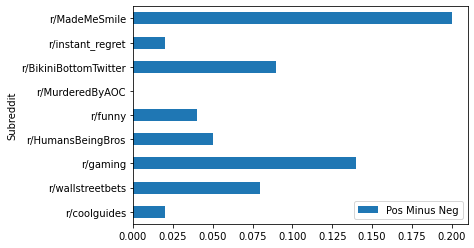

In [452]:
scores_df.iloc[0:9].plot.barh(x='Subreddit',y='Pos Minus Neg')

<AxesSubplot:ylabel='Subreddit'>

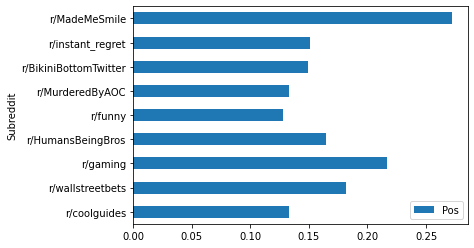

In [453]:
scores_df.iloc[0:9].plot.barh(x='Subreddit',y='Pos')

<AxesSubplot:ylabel='Subreddit'>

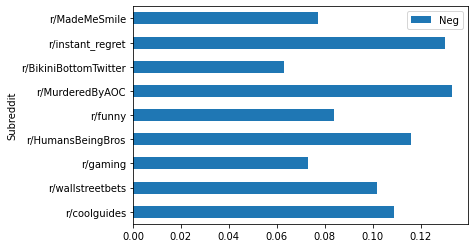

In [454]:
scores_df.iloc[0:9].plot.barh(x='Subreddit',y='Neg')